## 0. Import

In [2]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import functions
 
# convert mesh to pv_mesh
def tri_to_pv(tri_mesh):
    faces = np.pad(tri_mesh.faces, ((0, 0),(1,0)), 'constant', constant_values=3)
    pv_mesh = pv.PolyData(tri_mesh.vertices, faces)
    return pv_mesh

In [3]:
envelope_path = os.path.relpath('../data/meshes/compulsory_envelope.obj')
context_path = os.path.relpath('../data/meshes/immediate_context.obj')

# load the mesh from file
envelope_mesh = tm.load(envelope_path)
context_mesh = tm.load(context_path)

# Check if the mesh is watertight
print(envelope_mesh.is_watertight)
print(context_mesh.is_watertight)

True
False


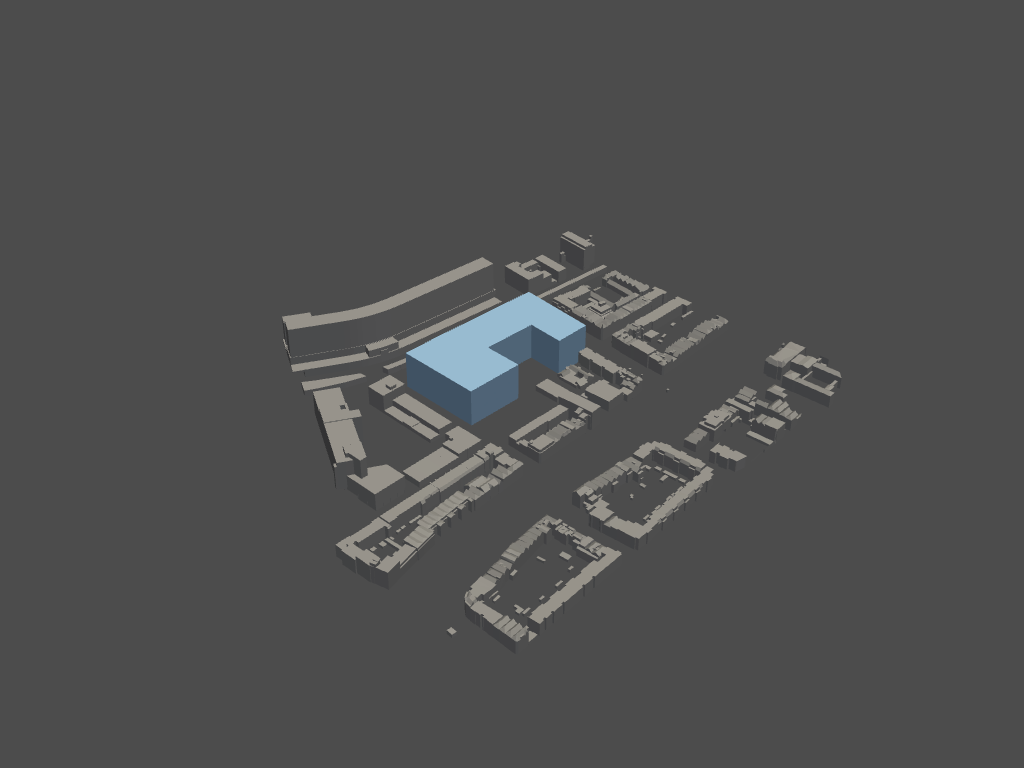

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]

In [4]:
# initiating the plotter
p = pv.Plotter(notebook=True)

# adding the meshes
p.add_mesh(tri_to_pv(envelope_mesh), color='#abd8ff')
p.add_mesh(tri_to_pv(context_mesh), color='#aaaaaa')

# plotting
p.show()

In [5]:
# load lattices from before
lattice_path = os.path.relpath('../data/meshes/voxelized_envelope.csv')
envelope_lattice = tg.lattice_from_csv(lattice_path)

lattice_path = os.path.relpath('../data/meshes/voxelized_envelope_highres.csv')
envelope_lattice_highres = tg.lattice_from_csv(lattice_path)

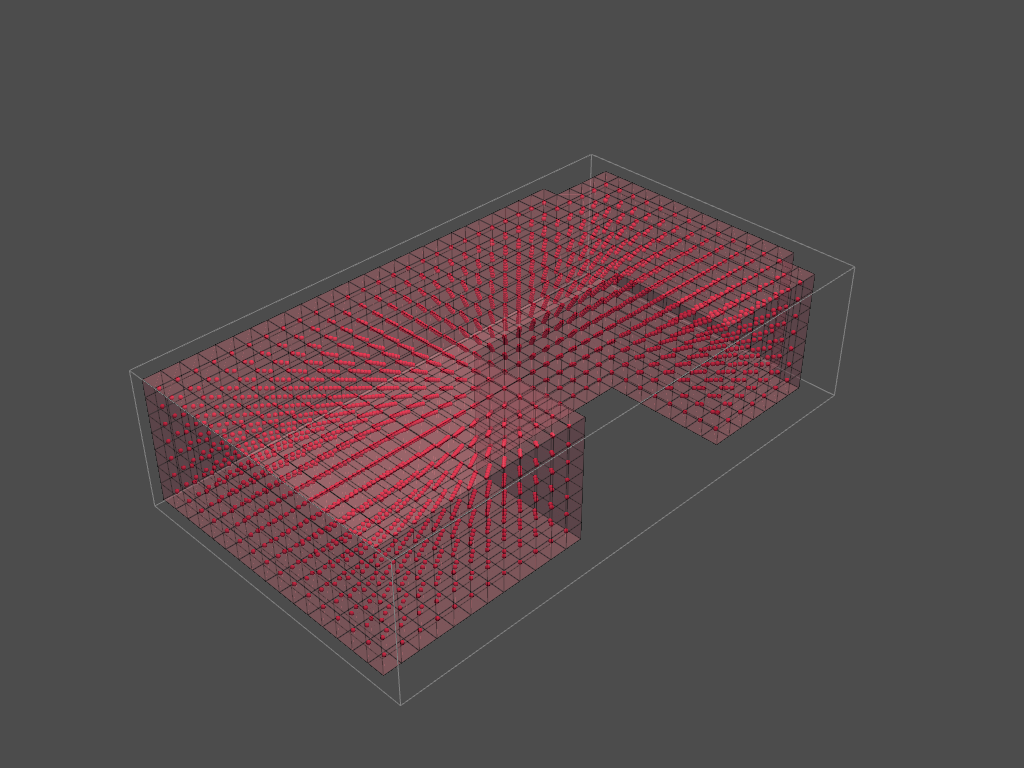

[(239.8279062084888, 147.3279062084888, 222.3279062084888),
 (35.0, -57.5, 17.5),
 (0.0, 0.0, 1.0)]

In [6]:
# initiating the plotter
p = pv.Plotter(notebook=True)

# adding the meshes
envelope_lattice_highres.fast_vis(p)

# plotting
p.show()

## 1. Creating points to represent the sky

### 1.1 A sphere of points

In [7]:
# creating a sphere mesh
sphere_mesh = tm.creation.icosphere(subdivisions=3, radius=1000, color=None)

### 1.2 Take only the hemisphere

In [8]:
# take only the points that lie on the upper hemisphere and turn them into point cloud
sky_cloud = tg.cloud(sphere_mesh.vertices[np.where(sphere_mesh.vertices[:,2] >= 0)])

### 1.3 Plot the sky points

In [9]:
# plotting the points
p = pv.Plotter(notebook=True)

# adding the meshes
sky_cloud.fast_notebook_vis(p)
envelope_lattice.fast_vis(p)
#p.add_mesh(tri_to_pv(sphere_mesh), color='#aaaaaa', style='wireframe')
p.add_mesh(tri_to_pv(context_mesh), color='#aaaaaa')
# plotting
p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(3347.928268719119, 3347.928268719119, 3845.428268719119),
 (0.0, 0.0, 497.5),
 (0.0, 0.0, 1.0)]

## 2. Calculate the intersection between the voxels and sky points

### 2.1 Preparing the ray origins and directions

In [10]:
full_lattice = envelope_lattice * 0 + 1

#extract centroids
origin = full_lattice.centroids

# all the ray origins for each sky directions (vectorization format)
ray_srcs = np.tile(origin, [1, len(sky_cloud)]).reshape(-1, 3)

# all the ray directions for each centroid
ray_dirs = np.tile(sky_cloud, [len(origin), 1]) - ray_srcs

### 2.2 Intersect with the context mesh

In [11]:
# calculate all intersections to the context mesh
tri_id, ray_id = context_mesh.ray.intersects_id(ray_origins=ray_srcs, ray_directions=ray_dirs, multiple_hits=False)

### 2.3 Accumulate all the intersections to the context mesh per centroid

In [12]:
# initialize the 'hits' array with 0
hits = np.full((len(ray_dirs)), 0)

# rays that hit the context mesh are set to 1
hits[ray_id] = 1

# reshape the 'hits' array to (len(centroids), len(directions))
hits = hits.reshape(len(full_lattice.centroids), -1)

# sum up all the intersections per centroid
vox_hits = np.sum(hits, axis=1)

# calculate the percentage that doesn't hit the context mesh
vox_sky_acc = 1.0 - vox_hits / len(sky_cloud)

### 2.4 Store sky accessiblity into lattices

In [13]:
# # take the indices of voxels that are in the mesh
# env_in_lattices_id = envelope_lattice.indices.flatten()[envelope_lattice.flatten()]

# # initialize the sky access values for all centroids with 0s
# all_vox_sky_acc = np.full(len(envelope_lattice.flatten()), 0.0)

# # all voxels inside the mesh will be with the values of 'vox_sky_acc' calculated in the cell above
# all_vox_sky_acc[env_in_lattices_id] = vox_sky_acc

# # reshape it back
all_vox_sky_acc = vox_sky_acc.reshape(envelope_lattice.shape)

# turn them into lattices for later plotting
all_vox_sky_acc_lattices = tg.to_lattice(all_vox_sky_acc, envelope_lattice)


### 2.5 Plot the sky accessibility

In [14]:
# initiating the plotter
p = pv.Plotter(notebook=True)

l = all_vox_sky_acc_lattices

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = l.shape
# The bottom left corner of the data set
grid.origin = l.minbound
# These are the cell sizes along each axis
grid.spacing = l.unit

# Add the data values to the cell data
grid.point_arrays["Sky View Factor"] = l.flatten(order="F")  # Flatten the Lattice
    
# adding the volume
opacity = np.array([0,0.6,0.6,0.6,0.6,0.6,0.6])*1.5

p.add_volume(grid, cmap="RdYlBu", clim=[0.5, 1.0],opacity=opacity, shade=True)

# plotting
p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(229.78838913964287, 134.78838913964287, 214.78838913964287),
 (35.0, -60.0, 20.0),
 (0.0, 0.0, 1.0)]

In [15]:
sky_acc_highres = functions.interpolate(all_vox_sky_acc_lattices, envelope_lattice_highres)
# sky_acc_highres=sky_acc_highres*envelope_lattice_highres

In [16]:
# initiating the plotter
p = pv.Plotter(notebook=True)

vis_lattice = sky_acc_highres
# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = vis_lattice.shape
# The bottom left corner of the data set
grid.origin = vis_lattice.minbound
# These are the cell sizes along each axis
grid.spacing = vis_lattice.unit

# Add the data values to the cell data
grid.point_arrays["Sky access Highres"] = vis_lattice.flatten(order="F")  # Flatten the Lattice

# adding the volume
opacity = np.array([0,0.6,0.6,0.6,0.6,0.6,0.6])*1.5
p.add_volume(grid, cmap="RdYlBu", clim=[0.5, 1.0],opacity=opacity, shade=True)

# plotting
p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(231.22009113429812, 138.72009113429812, 213.72009113429812),
 (35.0, -57.5, 17.5),
 (0.0, 0.0, 1.0)]

## 4. Save to CSV

In [19]:
sky_acc_highres.to_csv(os.path.relpath('../data/fields/sky_view_factor.csv'))

In [20]:
lattice_path = os.path.relpath('../data/fields/sky_view_factor.csv')
envelope_lattice_32 = tg.lattice_from_csv(lattice_path)

envelope_lattice_32.shape

(31, 18, 8)